# pset04: a plague of sand mice
*by Xingyu (Luna) Li , Sep 30th, 2021*
  
## Background
A strange new disease is sweeping through the sand mouse population. My lab is trying to obtain genomic and transcriptomic sequence of the pathogen, by sequencing RNA from infected mice. Pathogen sequences make up a small fraction of the RNA-seq reads(1%), mixed with a large majority of sand mouse sequences (99%).  
   
The lab has collected datasets that are available for training and testing methods:
- pathogen.fa: 10,000 pathogen sequences of length 200, in FASTA format.
- sandmouse.fa: 10,000 sand mouse sequences, also of length 200 and in FASTA format. 
  
Moriarty scored the 10,000 pathogen sequences in pathogen.fa using +1 for each A or T and -1 for each C or G, compared to scoring 10,000 random sequences of uniform base composition. Here are his results:  
  
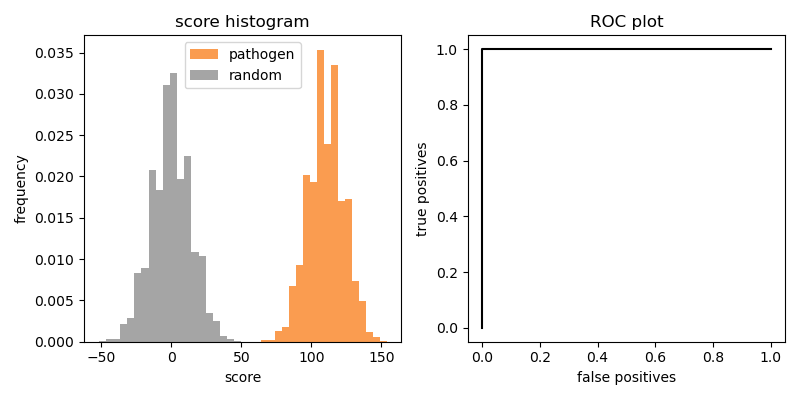    

## 1. Test Moriarty's Method
Moriarty only showed results for discriminating against random sequences, so I am going to repeat his analysis to **discriminate against sand mouse sequences**.  

In [1]:
# Have a look at the data
! head -5 pathogen.dnas
! head -5 sandmouse.dnas

>pathogen.1
TTTTATAGCTTAAATTAATCTTGCAATAATACAATGGTGCTCCAATTATCATAAGAAAATACTTTAAGAAATAGAATTATCTATAGAGTCCTTATCTGTCTTGTTTATATGAGACAGTTAATTTGAAGAAGGAATAATCTTTCCGTTTTTAGATATTAAAATAATTATACCTCATTAAAGTTTTCAGATAATTTCTAGAA
>pathogen.2
ATTTATGAAAGATTTTTTCTATTTTTTATAGATGTCTATTCTGTGAATTTTCAATAAACGATTTTAGTACAAAGTATATAACTGCACATGCTGTAGATGTATTAAAAAAATTCTAACAGATTAAGAAGATTAAAATGGAAATGTTCTCCGAAATGTTGGAAACATAGAAATTAAAACTATTTATAAGGTTAAAGCTGTTT
>pathogen.3
>sandmouse.1
GATAAATAACACATTTTTCTATATATCATTATTTGTTATATGATTATAATATAATTATTTAAAAACTAGAATTTGCAAATGCATATATATGTGAAATTTTATATTAATTAAGTATGAAAAATGGAGTAGAATAAAAAATTAATATAAATTAATTAAAACAAAGTACAGATAAATCTATGTAAATTATCATAAAATATGGA
>sandmouse.2
TGGTTAAACAGTTTCGAAATTAGTAAGTAAAGTGAAGTGTATATAGAATGAGTATTTTAAAAATCATAACTAAGAACTGTAAATACTATATATTATAATAACCAACTACTTATTAATTATTAATTTTTTAAATTTTGTAAAATTAGTCAATTTGTTAATTATTAATATCGGTAAATGCTCATGCTTTAGACATGCTATAA
>sandmouse.3


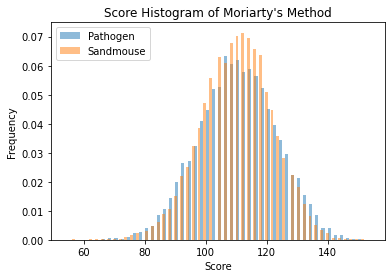

In [2]:
# Read the data
def read_fasta(file):
    seq = []
    with open(file, "r") as infile:    
        for line in infile:
            line = line.strip()          # remove the blank space and line break
            if not line.startswith(">"): # skip the header line begins with ">"
                seq.append(line)
    return seq
pathogen = read_fasta("pathogen.dnas")
sandmouse = read_fasta("sandmouse.dnas")

# Calculate scores for each sequence
import numpy as np
def score_moriarty(data):
    score = np.zeros(len(data))          # initialize score array with zeroes
    for i in range(len(data)):
        for j in range(len(data[i])):
            if data[i][j] in ['A','T']:   # +1 for each A or T
                score[i] += 1
            elif data[i][j] in ['G','C']: # -1 for each G or C
                score[i] -= 1
            else: print("Error! There is a %s nucleotide!" %(seq[i])) # warn if other characters in the seq
    return score
score_moriarty_p = score_moriarty(pathogen)
score_moriarty_s = score_moriarty(sandmouse)

# Make a plot of the scores
import matplotlib.pyplot as plt
plt.hist(score_moriarty_p, density = True, bins = 100, alpha = 0.5, label = 'Pathogen')
plt.hist(score_moriarty_s, density = True, bins = 100, alpha = 0.5, label = 'Sandmouse')
plt.legend(loc='upper left')
plt.ylabel('Frequency')
plt.xlabel('Score')
plt.title('Score Histogram of Moriarty\'s Method')
plt.show()

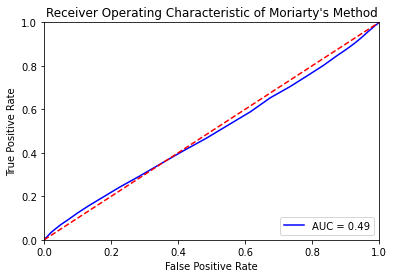

In [3]:
# Draw the ROC plot
import numpy as np
labels = np.array([0,1]).repeat(10000) # generate the labels, 0 for sandmouse sequence and 1 for pathogen sequence
scores = np.concatenate([score_moriarty_s,score_moriarty_p])   # concatenate the scores and convert it to a numpy array

# Define a function to give out classification results according to different thresholds
def classification_results(scores, labels, granularity):
    thresholds = np.linspace(min(scores),max(scores),granularity) # iterate through max to min of scores
    FPR = []; TPR = []
    for threshold in thresholds:
        TP, FP, FN, TN = np.zeros(4)  # initialize the classification counts
        for i in range(len(scores)):  # iterate through each scores and labels
            if scores[i] > threshold:
                if labels[i] == 1:
                    TP += 1           # true positive
                else: FP += 1         # false positive
            elif labels[i] == 1: 
                FN += 1               # false negative
            else: TN += 1             # true negative
        FPR.append(FP / (TN + FP))
        TPR.append(TP / (TP + FN))
    return FPR, TPR

# Calculate the TPR and FPR
FPR, TPR = classification_results(scores, labels, 1000)

    # or there's a 'metrics' module in sklearn: FPR, TPR, thresholds = metrics.roc_curve(labels, scores)

# Calculate the Area Under Curve
from numpy import trapz  # use the Trapezoidal rule
auc = 1 - abs(trapz(FPR, TPR, dx=0.001))
    # or auc = metrics.auc(fpr, tpr) 

# Draw the ROC plot
plt.title('Receiver Operating Characteristic of Moriarty\'s Method')
plt.plot(FPR, TPR, 'b', label = 'AUC = %0.2f' % auc)  # draw the ROC curve and label the AUC
plt.legend(loc = 'lower right')  
plt.plot([0, 1], [0, 1],'r--')         # draw a reference line of y = x
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

The distribution of pathogen and sandmouse sequences' scores are very similar in the histogram. Moreover, the ROC curve shows that the true positive rate (TPR) against the false positive rate (FPR) at various threshold settings are also very close, giving us a diagonal line with an AUC of 0.49.   
  
To sum up, Moriarty's scoring method does not work as well as he claims and is no different from **random guessing**.  
   
A possbible explanation is that for the random-generated sequence, the probability of A/Ts and G/Cs are same, so the score would be around zero. However, both sandmouse and pathogen sequences may be rich in As and Ts, resulting in two high scores that make it impossible to distinguish between the two.

## 2. Make My Own Method
Next, I am going to implement a **second order Markov model** to distinguish those sequences, which could be described simply as a model where we assume that the identity of position i depends on two previous positions i−1 and i-2.  

The first step would be spliting the dataset as training and testing, then estimating parameters for two models: one on pathogen, and one on sandmouse using the training dataset.

In [4]:
# Split up training and testing sets
def random_half(data):
    size = int(len(data)/2)                   # each set contains half the data
    data_random = np.random.permutation(data) # permutate the data for randomization
    train = data_random[0:size]               # choose the first half as training set
    test = data_random[size:len(data)]        # the second half as testing set
    return train,test
np.random.seed(99)      # set a seed for reproducibility
pathogen_train, pathogen_test = random_half(pathogen)
sandmouse_train, sandmouse_test = random_half(sandmouse)

Then, in order to calculate the total probability of a specific sequence from this model, two types of parameters are need to be defined: 
- The initial probability is the joint probability of a particular sequence of two nucleotides occurring. 
- The conditional probability is the probability of observing one specific nucleotide given the combination of the previous two. 
  
Therefore, I am going to find all the possible 2-mers and 3-mers, and get their frequencies:

In [5]:
# Find all 2-mers and 3-mers
from itertools import product
twomers = [''.join(i) for i in product('ATCG', repeat=2)]  # since itertools return tuples of characters as default,
threemers = [''.join(i) for i in product('ATCG', repeat=3)] # I add a .join() function to make them a string 

# Count the number of those 2- and 3-mers
def count_kmers(data, kmers):
    count = np.zeros(len(kmers))    # initialize the count number of 0s
    for seq in data:                # iterate through each sequence
        for i in range(len(kmers)): # and each k-mers
            count[i] += seq.count(kmers[i]) # count the number of that k-mers in the sequence
    return count
n_two_p = count_kmers(pathogen_train,twomers)
n_three_p = count_kmers(pathogen_train,threemers)
n_two_s = count_kmers(sandmouse_train,twomers)
n_three_s = count_kmers(sandmouse_train,threemers)

# Normalize counts to get frequencies
p_two_p = n_two_p / sum(n_two_p)
p_three_p = n_three_p / sum(n_three_p)
p_two_s = n_two_s / sum(n_two_s)
p_three_s = n_three_s / sum(n_three_s)
model = [p_two_p,p_three_p,p_two_s,p_three_s]

After we got the frequencies, we can use the normalized frequencies of 2-mers as our initial probabilities, and calculate our conditional probabilities by dividing the probabilites of a specific 3-mers by their according 2-mers:

In [6]:
# Set the initial probabilities
initial_prob = [p_two_p, p_two_s]

# Calculate the conditional probabilities
def conditional_prob(threemer_freq, twomer_freq):
    conditional_prob = np.zeros(len(threemer_freq))
    for i in range(len(threemer_freq)):
        conditional_prob[i] = threemer_freq[i]/twomer_freq[twomers.index(threemers[i][0:2])]
    return conditional_prob
conditional_prob = [conditional_prob(p_three_p,p_two_p),conditional_prob(p_three_s,p_two_s)]

# Store them in a model
model = [initial_prob, conditional_prob]

Now our parameters for the model are all set, we can then use the testing dataset to see if it's working properly:

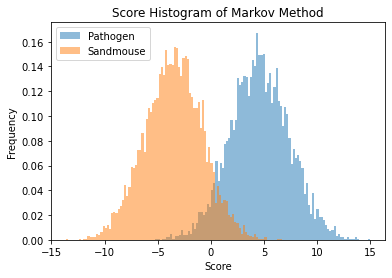

In [7]:
# Calculate the probability of each sequence given the two Markov models
def score_markov(data, model):
    score = np.zeros(len(data))  # initialize score array
    for j in range(len(data)):   # iterate through each sequence
        prob_p = np.log(model[0][0][twomers.index(data[j][0:2])]) # calculate the (log) initial probability of the 
        prob_s = np.log(model[0][1][twomers.index(data[j][0:2])]) # first two nucleotides for each model
        for i in range(2, len(data[j])-3): # iterate through each nucleotide of the sequence
            prob_p += np.log(model[1][0][threemers.index(data[j][i:i+3])]) # calculate the (log) probability of each 
            prob_s += np.log(model[1][1][threemers.index(data[j][i:i+3])]) # nucleotide, given the previous two nucleotides
        score[j] = prob_p - prob_s # calculate log odds score (for accuracy, I have logged them in previous steps)
    return score
score_markov_p = score_markov(pathogen_test,model)
score_markov_s = score_markov(sandmouse_test,model)

# Make a plot of the scores
import matplotlib.pyplot as plt
plt.hist(score_markov_p, density = True, bins = 100, alpha = 0.5, label = 'Pathogen')
plt.hist(score_markov_s, density = True, bins = 100, alpha = 0.5, label = 'Sandmouse')
plt.legend(loc='upper left')
plt.ylabel('Frequency')
plt.xlabel('Score')
plt.title('Score Histogram of Markov Method')
plt.show()

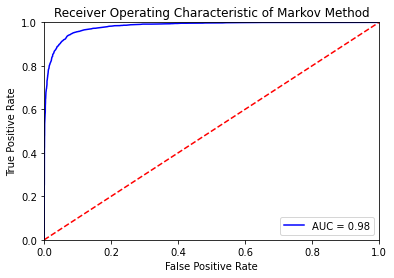

In [8]:
# Calculate the fpr and tpr for all thresholds
labels = np.array([0,1]).repeat(5000) # generate the labels, 0 for sandmouse sequence and 1 for pathogen sequence
scores = np.concatenate([score_markov_s,score_markov_p])   # concatenate the scores and convert it to a numpy array
FPR, TPR = classification_results(scores, labels, 1000)

# Calculate the Area Under Curve
from numpy import trapz  # use the Trapezoidal rule
auc = 1 - abs(trapz(FPR, TPR, dx=0.001))

# Draw the ROC plot
plt.title('Receiver Operating Characteristic of Markov Method')
plt.plot(FPR, TPR, 'b', label = 'AUC = %0.2f' % auc)  # draw the ROC curve and label the AUC
plt.legend(loc = 'lower right')  
plt.plot([0, 1], [0, 1],'r--')         # draw a reference line of y = x
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

An AUC of 0.98 implies that our second order Markov model works pretty well.

## 3. How Good is My Method?
Suppose the lab needs to achieve 90% sensitivity (i.e. detecting 90% of pathogen sequences), I am going to determine the score threshold that needs to be set, and estimate the false positive rate at that threshold.

In [9]:
def set_threshold(scores, labels, sensitivity):
    thresholds = np.arange(round(max(scores),2),round(min(scores),2),-0.01) # iterate through max to min of scores
    for threshold in thresholds:
        TP, FP, FN, TN = np.zeros(4)  # initialize the classification counts
        for i in range(len(scores)):  # iterate through each scores and labels
            if scores[i] > threshold:
                if labels[i] == 1:
                    TP += 1           # true positive
                else: FP += 1         # false positive
            elif labels[i] == 1: 
                FN += 1               # false negative
            else: TN += 1             # true negative
        tpr = TP / (TP + FN)
        counts = [TP,FP,FN,TN]
        if tpr >= sensitivity:        # return the threshold and results when achieving 
            return threshold,counts
threshold_90,results = set_threshold(scores,labels,sensitivity = 0.9)
print("The threshold that achieves 90% sensitivity is {:.2f}.".format(threshold_90))

The threshold that achieves 90% sensitivity is 1.05.


In [10]:
# Estimate the FPR and FDR at that threshold
FPR = results[1] / (results[1] + results[3])
FDR = results[1] / (results[1] + results[0])
print("If the proportion of pathogen reads to sandmouse reads is 1:1, the false postive rate would be {0:.2%}, the false discovery rate would be {1:.2%}.".format(FPR,FDR))

If the proportion of pathogen reads to sandmouse reads is 1:1, the false postive rate would be 4.56%, the false discovery rate would be 4.82%.


Since in an RNA-seq sample from an infected sand mouse, only 1% of the reads are from the pathogen, and 99% of the reads are from the mouse, we would need to estimate the FDR according to their relative proportion.  
   
The FDR is the expected ratio of the number of false positive classifications to the total number of positive classifications. Because false positives are sampled from the sandmouse reads and true positives are sampled from the pathogen reads, we can simply estimate them by multiply their relative proportion:

In [11]:
# Estimate the FDR when taking the proportion of the reads into account
proportion = 99   # reads from sandmouse : pathogen  = 99 : 1
FDR_prop = results[1]*proportion / (results[1]*proportion + results[0])
print("If the proportion of pathogen reads to sandmouse reads is 1:{0:d}, the false discovery rate would be {1:.2%}.".format(proportion,FDR_prop))

If the proportion of pathogen reads to sandmouse reads is 1:99, the false discovery rate would be 83.38%.


In [12]:
# I have also tried to use the codes below to directly simulate the data, but it takes so much time (5 mins?) to run, 
# so instead I choose to calculate the FDR myself. (The results would be the same.)

# # use the test data to simulate the RNA-seq sample
# proportion = 99   # reads from sandmouse : pathogen  = 99 : 1
# scores_prop = np.concatenate([score_markov_s.repeat(proportion),score_markov_p]) # repeat sandmouse test reads 'proportion' times
# labels_prop = np.concatenate([np.zeros(5000*proportion),np.ones(5000)]) # generate the corresponding labels

# # estimate the FDR
# threshold_90_prop,results_prop = set_threshold(scores_prop,labels_prop,sensitivity = 0.9)
# FPR_prop = results_prop[1] / (results_prop[1] + results_prop[3])
# FDR_prop = results_prop[1] / (results_prop[1] + results_prop[0])
# print("If the proportion of pathogen reads to sandmouse reads is 1:{0:d}, The threshold that achieves 90% sensitivity is {1:.2f}.".format(proportion,threshold_90_prop))
# print("If the proportion of pathogen reads to sandmouse reads is 1:{0:d}, the false postive rate would be {1:.2%}, the false discover rate would be {2:.2%}.".format(proportion,FPR_prop,FDR_prop))

We can see that since only a small proportion of the RNA-seq reads are from the pathogen, the false discovery rate could be really large and there would be a lot of noise drowning out the signal.